number of iterations = 55105


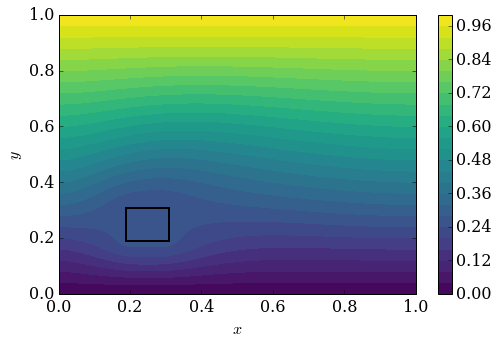

In [38]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# resolution 
nx=150
ny=150
    
# cavity of length l and height h
l=1
h=1

# speed of the flow u
u=1
#grid
x=numpy.linspace(0,l,nx)
y=numpy.linspace(0,h,ny)
dx=l/(nx-1)
dy=h/(ny-1)

#norm target
l1_target = 1e-6

#dimension of the square
r=int((nx-1)/15)
#position of the center of the square
xi=int((nx-1)/4)
yi=int((ny-1)/4)

#potential flow
w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))

#initial guess of psi=u*y on the cavity's boundaries
psi[:,0]=u*y[:]
psi[:,-1]=u*y[:]
psi[-1,:]=u*y[-1]
psi[0,:]=u*y[0]

def L1norm(new, old):
    '''compute the norm between psi(k+1) and psi(k)
    
    Parameters:
    ----------
    new : 2D array of floats
        psi(k+1)
    old: 2D array of floats
        psi(k)
        
    Returns:
    -------
    norm: float
        norm between psi(k) and psi(k+1)
    ''' 
    norm = numpy.sum(numpy.abs(new-old))
    return norm

def BCs_obstacle(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-7*psi[yi,xi-r-1]-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-7*psi[yi,xi-r-1]-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-7*psi[yi,xi-r-1]-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-7*psi[yi,xi-r-1]-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

def stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,y):
    '''Performs Jacobi relaxation for the cavity flow
    
    Parameters:
    ----------
    w : 2D array of floats
        Initial guess
    psi: 2D array of floats
        Initial guess
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l1_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after relaxation
    iteration: number of iteration
    ''' 
    iteration=0
    stop1=1
    stop2=1
    psin = numpy.empty_like(psi)
    wn= numpy.empty_like(w)
    
    while(stop1>l1_target or stop2>l1_target):
        
        psin=psi.copy()
        wn=w.copy()
        w[1:-1,1:-1]=.25*(wn[2:,1:-1]+wn[:-2,1:-1]+w[1:-1,:-2]+wn[1:-1,2:])
        
        psi[1:-1:,1:-1]=.25*((dx**2)*wn[1:-1,1:-1]+psin[2:,1:-1] \
                             +psin[:-2,1:-1]+psi[1:-1,:-2]+psin[1:-1,2:]) 
        
        psi,w = BCs_obstacle(w,psi,y,xi,yi,r,h,u)  
        
        stop1=L1norm(psi,psin)
        stop2=L1norm(w,wn)
        iteration+=1
        
    return psi, iteration

#contour plot of the stream function
psi,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,y)
print("number of iterations =",iteration)

j=numpy.linspace(x[xi-r],x[xi+r],100)
p=numpy.linspace(y[yi-r],y[yi+r],100)
k=numpy.zeros(100)
l=numpy.zeros(100)
m=numpy.zeros(100)
n=numpy.zeros(100)
k[:]=x[xi+r]
l[:]=x[xi-r]
m[:]=y[yi+r]
n[:]=y[yi-r]
pyplot.figure(figsize=(8,5))
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.contourf(x,y,psi,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

4.67243730461e-05


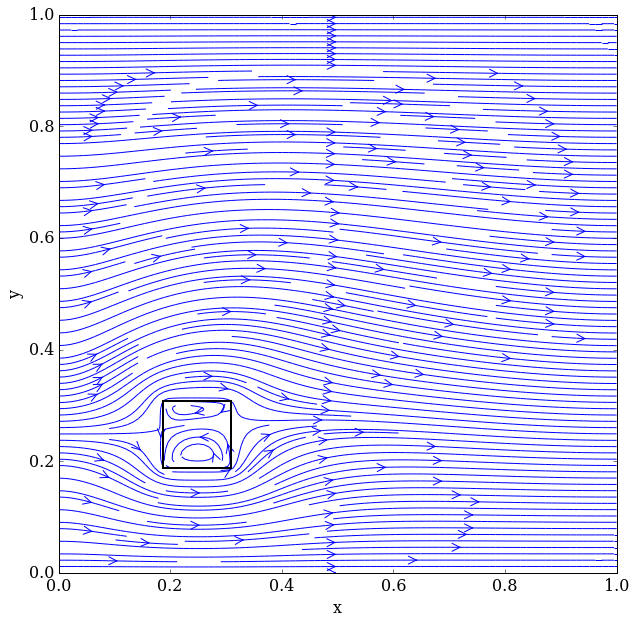

In [39]:
def speed(psi,nx,ny,dx,dy):
    '''calculate the speed from the potential
    
    Parameters:
    ----------
    psi : 2D array of floats
        potential
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    ux: 2D array of float
        speed in the x direction
    vy:2D array of float
        speed in the y direction
    ''' 
    ux=numpy.zeros((nx,ny))
    vy=numpy.zeros((nx,ny))
    
    ux[:,0]=u
    ux[:,-1]=u
    ux[0,:]=u
    ux[-1,:]=u
    ux[1:-1,1:-1]=(1/2*dy)*(psi[2:,1:-1]-psi[0:-2,1:-1])
    
    vy[:,0]=0
    vy[:,-1]=0
    vy[0,:]=0
    vy[-1,:]=0
    vy[1:-1,1:-1]=-(1/2*dx)*(psi[1:-1,2:]-psi[1:-1,0:-2])
    
    return ux,vy

#plot of the flow speed
ux, vy=speed(psi,nx,ny,dx,dy)
X, Y =numpy.meshgrid(x,y)
size=10

print(ux[120,120])

pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, ux, vy, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

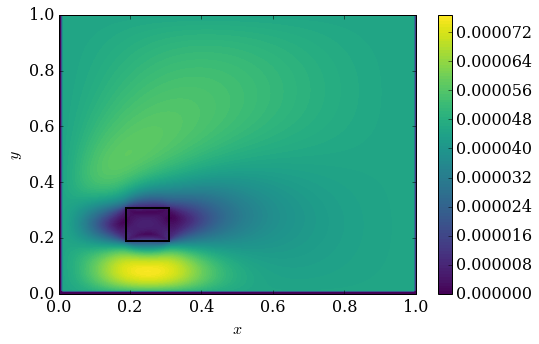

In [40]:
u2=numpy.zeros((nx,ny))

u2[2:ny-1,2:nx-1]=numpy.sqrt(((ux[2:ny-1,2:nx-1])**2+(vy[2:ny-1,2:nx-1])**2))
pyplot.figure(figsize=(8,5))
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.contourf(x,y,u2,100,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [23]:
print(psi[15,15])

0.10324356711
